<center>
    <H1> Introduction to Julia </H1>
<img src="julia.png" width="400"/>
</center>


## Outline

- *Julia* as a language for numerical Computation
- Functional aspects
- Types
- Multiple Dispatch
- Parallelism
- Extensibility

## A language for numerical computation

*Julia*'s  syntax is very similar to langages as *Matlab*, *Python* or *Scilab*, so
switching to *Julia* is fast

- do not require *vectorized* code to run fast using a LLVM-JIT compiler

In [1]:
using LinearAlgebra, Test
function f1(n::Int)
    A=zeros(Int64, n,n);
    for j=1:n ## Fortran Loop Style  !!!!
        for i=1:n
            A[i,j] = i^j
        end
    end
    return A
end    
@elapsed f1(10^4)

1.377285742

In [2]:
function f2(n::Int) 
   A = collect(1:n).^collect(1:n)'
   return A
end
#@test f1(3) == f2(3)
@elapsed f2(10^4)

1.445059204

- structs have a objects semantic value (i.e. references)

In [3]:
a = [1,2]
b = a 
a[1] = 4
b

2-element Array{Int64,1}:
 4
 2

- indices start to 1 and finish to `end` and use brackets `[,]` for indexing

In [4]:
a = rand(2,2)
a[:, end] .= 1
a

2×2 Array{Float64,2}:
 0.890128  1.0
 0.654133  1.0

- it supports broadcasting, ie. `(1,n)` and `(m, n)` → `(m,n)` and `(m,n)`

In [5]:
using Statistics
a=rand(3,3)
μ=mean(a, dims=1)
mean(a.-μ, dims=1)

1×3 Array{Float64,2}:
 1.85037e-17  1.11022e-16  1.85037e-17

- 1D arrays support

In [6]:
typeof(rand(3,1))

Array{Float64,2}

In [7]:
typeof(rand(3))

Array{Float64,1}

- Unicode symbol for notation and some operations 

In [8]:
√Complex(-1)

0.0 + 1.0im

## Functionals aspects

- list comprehensions

In [9]:
hilbert(n::Int) = reshape([ 1//(i+j-1) for i=1:n for j=1:n],n,n)
H₃=hilbert(3) 
det(H₃)

1//2160

- Anonymous functions : `(x -> x*x)(2) `
- supports for `map`, `reduce`, `filter` functions

In [10]:
# seeking integers between squares and cubes
supSquares = filter(x->abs(√(x-1)-round(√(x-1))) < 1e-12, 1:100)
infCubes = filter(x->abs(∛(x+1)-round(∛(x+1))) < 1e-12, 1:100)
ξ = intersect(supSquares, infCubes)

1-element Array{Int64,1}:
 26

- functions support variadic arguments (using tuples or names)
- functions are not supposed to modify their arguments, otherwise they follow the `!` convention like `sort!`

In [11]:
s=[4,1,3]; println("sort(s)=",sort(s));println("s=",s); sort!(s); println("s=",s)

sort(s)=[1, 3, 4]
s=[4, 1, 3]
s=[1, 3, 4]


- support metaprogramming : like in Lisp "Code is data and data is code"

In [12]:
e = :(2+2); println(typeof(e)); println(e.args); println(eval(e))

Expr
Any[:+, 2, 2]
4


## Types
Julia has a hierarchy of types defined by a graph with `Any` as a root

In [13]:
subtypes(Real)

4-element Array{Any,1}:
 AbstractFloat     
 AbstractIrrational
 Integer           
 Rational          

In [83]:
println("supertype of Real → ", supertype(Real))
println("supertype of Number → ",supertype(Number))

supertype of Real → Number
supertype of Number → Any


- `x<:y` is the operator for the relation "x is a subtype of y"

In [14]:
Int64 <: Real

true

- some types are abstract (e.g `Real`) → cannot be instantiate

In [15]:
typeof(Real(1.2))

Float64

some types are concrete (e.g. `Int64`) → they have not subtype except `Union{}`

In [16]:
subtypes(Int64)

0-element Array{Type,1}

In [17]:
Union{}<:Int64

true

## To extend basic types, *Julia* supports
- composite types trough `struct` and `mutable struct`

In [85]:
struct zutos
    x::Int
    a::Array{Int64,1}
end 
w = zutos(2, [1,2])

zutos(2, [1, 2])

In [86]:
w.x = 4

ErrorException: setfield! immutable struct of type zutos cannot be changed

In [87]:
append!(w.a,3)'

1×3 Adjoint{Int64,Array{Int64,1}}:
 1  2  3

- tuple types

In [21]:
typeof((3,"haha"))

Tuple{Int64,String}

In [22]:
Tuple{Int64,String} <: Tuple{Real,String}

true

- union types

In [23]:
Real <: Union{String, Real}

true

- parametric types 

In [24]:
struct tableau{T<:Number}
    n::Int64
    a::Ptr{T}
end
a = tableau{Int64}(10, 0)

tableau{Int64}(10, Ptr{Int64} @0x0000000000000000)

☢ For efficiency, parametric types are invariants, except Tuples ☢

In [25]:
Array{Int64} <: Array{Real}

false

## Multiple Dispatch
- When Julia executes a function it selects a *method* respect to types of all arguments  : Thus, we can define 
function piecewisely respectivly to the whole of its arguments

- no automatic or magic conversions : for operators  arguments are promoted to a common type (user-definable) and use the specific implementation


In [26]:
@code_lowered 1+2.

CodeInfo(
1 ─ %1 = Base.promote(x, y)
│   %2 = Core._apply(Base.:+, %1)
└──      return %2
)

- let us define `f`

In [27]:
f(x::Float64,y::Float64) = 2x + y
f(x::Int,y::Int) = 2x + y
println(f(2.,3.));
println(f(2,3));
println(f(2,3.));

7.0
7


MethodError: MethodError: no method matching f(::Int64, ::Float64)
Closest candidates are:
  f(::Int64, !Matched::Int64) at In[27]:2
  f(!Matched::Float64, ::Float64) at In[27]:1

- but if we define `f`

In [89]:
    f(x::Real, y::Real) = 2x + y
    f(2.0, 3) 

7.0

In [29]:
methods(f)

# 3 methods for generic function "f":
[1] f(x::Int64, y::Int64) in Main at In[27]:2
[2] f(x::Float64, y::Float64) in Main at In[27]:1
[3] f(x::Real, y::Real) in Main at In[28]:1

## Parallelism
Julia support parallelism trough differents ways
- native distributive parallelism with one master and workers 
- native shared parallelism  → macros `@threads, @spawn, @wait`
- trough MPI.jl could support distributed parallelism
- could support GPU trough packages (not treated)

## Native distributed parallelism 
- low level routines


In [30]:
using Distributed
addprocs(3)
nprocs()

4

In [31]:
res1 = @spawnat 2 sum(rand(1000,1000).^2)
res2= @spawnat 3 sum(rand(1000,1000).^2)
fetch(res1)+fetch(res2)

666097.769417492

- high level routines

In [32]:
@everywhere function f3(n::Int)
res = @distributed (+) for i=1:n
      sin(i*π/n)
end
return res
end
@time f3(200000000)

  2.105860 seconds (1.31 M allocations: 66.216 MiB, 0.63% gc time)


1.273239544735062e8

In [33]:
function f4(n::Int)
res =  0
for i=1:n
      res += sin(i*π/n)
end
return res
end
@time f4(200000000)

  3.601152 seconds (23.80 k allocations: 1.254 MiB)


1.2732395447358306e8

- example with `pmap`

In [34]:
@everywhere using Statistics 
@everywhere function cost_mean(x)
   s = zero(eltype(x))
   for i = 1:100
      s += mean(log(sin(exp(xi))) for xi in x)
   end
   return s
end
X = [rand(100_000) for j=1:20];
t1 = @elapsed map(cost_mean, X)
t2 = @elapsed pmap(cost_mean, X)
println("$t1, $t2")

8.996415173, 4.107689785


## threads support
- Threads supports is still experimental but works : ⚠️ think to use `export JULIA_NUM_THREADS=4` before launching Julia
with Julia-1.3, new task system was develop

In [35]:
using Base.Threads 
println(Base.Threads.nthreads())

4


- using a example taken from https://julialang.org/blog/2019/07/multithreading

In [47]:
import Base.Threads.@spawn

# sort the elements of `v` in place, from indices `lo` to `hi` inclusive
function psort!(v, lo::Int=1, hi::Int=length(v))
    if lo >= hi                       # 1 or 0 elements; nothing to do
        return v
    end
    if hi - lo < 100000               # below some cutoff, run in serial
        sort!(view(v, lo:hi), alg = MergeSort)
        return v
    end

    mid = (lo+hi)>>>1                 # find the midpoint

    half = @spawn psort!(v, lo, mid)  # task to sort the lower half; will run
    psort!(v, mid+1, hi)              # in parallel with the current call sorting
                                      # the upper half
    wait(half)                        # wait for the lower half to finish

    temp = v[lo:mid]                  # workspace for merging

    i, k, j = 1, lo, mid+1            # merge the two sorted sub-arrays
    @inbounds while k < j <= hi
        if v[j] < temp[i]
            v[k] = v[j]
            j += 1
        else
            v[k] = temp[i]
            i += 1
        end
        k += 1
    end
    @inbounds while k < j
        v[k] = temp[i]
        k += 1
        i += 1
    end

    return v
end

psort! (generic function with 3 methods)

In [48]:
a = rand(20000000);
b = copy(a); @time sort!(b, alg = MergeSort);   # single-threaded

  2.136703 seconds (111.25 k allocations: 81.999 MiB)


In [49]:
b = copy(a); @time sort!(b, alg = MergeSort);

  2.054423 seconds (11 allocations: 76.294 MiB)


In [50]:
b = copy(a); @time psort!(b);    # two threads

  1.002210 seconds (324.72 k allocations: 702.344 MiB, 5.35% gc time)


In [51]:
b = copy(a); @time psort!(b);

  0.841734 seconds (3.82 k allocations: 686.936 MiB)


In [38]:
using Base.Threads

f(x) = sin(x) + cos(x)

function serial(n)
    s = 0.0
    for x = 1:n
        s += f(x)
    end
    return s
end

@elapsed serial(10^7)

0.689574566

In [39]:
function threads(n)
    res_vec = zeros(nthreads())
    @threads for i ∈ 1:nthreads()
        res_vec[i] = local_sum(threadid(), n, nthreads())
    end
    sum(res_vec)
end

function local_sum(id, n, nthread)
    out = 0.0
    l = 1 + div(n * (id-1), nthread)
    u = div(n * id, nthread)
    for x ∈ l:u
        out += f(x)
    end
    out
end

@elapsed threads(10^7)

0.239562285

## Extensibility
 - *Julia* can be extended trough its trough packages `Pkg.add("MyPackage")` and `using MyPackage`
   - you can use `PyCall` to interact with `Python` → PyPlot package uses this mechanism
   - use MPI or GPU with packages
 - you can call functions from *C* or *Fortran* using ccall

In [52]:
io = open("skel.c","w")
write(io, "int ajoute2(int x) { return x+2; }")
close(io)
run(`gcc -o ajoute2.so --shared skel.c`);
w = ccall((:ajoute2, "./ajoute2.so"), Int32, (Int32,), 12)
run(`rm ajoute2.so skel.c`)
println("w = $w")

w = 14


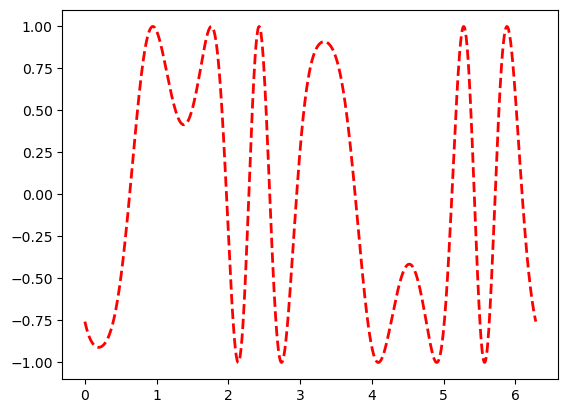

In [70]:
# example with matplotlib
using PyCall
using PyPlot
plt = pyimport("matplotlib.pyplot")
x = range(0;stop=2*pi,length=1000); y = sin.(3*x + 4*cos.(2*x));
plt.plot(x, y, color="red", linewidth=2.0, linestyle="--")
plt.show()

# calling a fortran MPI code trough Julia for optimizing
 - we want to minimize 
 
$$ f(x_1,...,x_{\#procs}) = \sum_{k=1}^{\#procs} \sum_{i=1}^{p_k}|x^k_i-c^k_i|^2 $$

- we use the following Julia code

```julia
...
function simu(x::Array{Float64,1})
    f = Ref{Float64}(0.)
    c = cos.(1:n)[slice[1]:slice[2]]
    df = zeros(slice[2]-slice[1]+1)
    @assert  size(c,1) == size(x, 1)
    ccall((:compute_error, "./libpar_error.so"), 
          Cvoid, (Ref{Int32}, Ptr{Float64}, Ptr{Float64}, Ref{Float64}, Ptr{Float64}), size(x, 1), x, c, f, df)
    return f[], df
end

function cost(x::Array{Float64,1})
    f,G = simu(x)
    return f
end

function grad(x::Array{Float64,1})
    f,G = simu(x)
    return G
end 

function main()
    MPI.Init()
    comm = MPI.COMM_WORLD
    nb_procs = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    global n, slice
    n = parse(Int32, ARGS[1])
    x = zeros(n)
    slice = compute_slice(n, Int32(nb_procs), Int32(rank))
    x[:] = 1:n
    x_loc = x[slice[1]:slice[2]]
    f,df = simu(x_loc)
 
    res = optimize(cost, grad, x_loc, BFGS(); inplace =false)
    x_min = Optim.minimizer(res)
    x_glob = MPI.Gatherv(x_min, Cint[5,5], 0, comm)
    if (rank == 0)
        println(" |sol - cos(1:$n)| = ", norm(x_glob-cos.(1:n)))
    end
    MPI.Finalize()
end
...
```

- and the evaluation of cost is done by a fortran code

```fortran
module par_error
    use mpi
    use iso_c_binding, only: c_int32_t, c_double
    public:: compute_error
contains

    subroutine compute_error(n, x, c, f, df) bind(C, name="compute_error")
        implicit none
        integer(c_int32_t), intent(in) :: n  ! size of the array
        real(c_double), intent(in) :: x(n), c(n) !
        real(c_double), intent(out) :: f
        real(c_double), intent(out) :: df(n)

        real(c_double) ::  f_loc
        integer(c_int32_t) :: code
        
        f = 0.d0
        ! computing objective
        f_loc = 0.5d0 * sum( (x - c)**2 )
        call MPI_ALLREDUCE( f_loc, f, 1, MPI_DOUBLE, MPI_SUM, MPI_COMM_WORLD, code )
        
        ! computing gradient and ...
        df = x - c
    end subroutine compute_error

end module par_error
```

In [80]:
a = read(`env LD_PRELOAD="/home/fux/sources/nahasketa/julia/interfaces/fortran/withMPI/libpar_error.so" mpirun -np 2 julia /home/fux/sources/nahasketa/julia/interfaces/fortran/withMPI/test_optim.jl  10`, String)

"cost function at x0 = 206.1740675143132\n |sol - cos(1:10)| = 9.961119953842058e-16\n"

## to Conclude
- julia is a *fast* language for doing numerical computations : good replacement for Matlab, R, or Python
- since 2012, the community (numericians and computer scientists) is growing
- In August 2018, the version 1.0 was published
- have a look at https://julialang.org/